## Описание проекта. Телеком

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.\
\
**Описание услуг**\
Оператор предоставляет два основных типа услуг:\
1) Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.\
2) Интернет. Подключение бывает двух типов: через телефонную линию DSL (англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (англ. fiber optic).\
\
Также абонентам доступен ряд услуг:
- Интернет-безопасность: антивирус (Device Protection) и блокировка опасных сайтов (Online Security);
- Выделенная линия технической поддержки (Tech Support);
- Облачное хранилище файлов для резервного копирования данных (Online Backup);
- Стриминговое телевидение (Streaming TV) и каталог фильмов (Streaming Movies).\
\
За услуги клиенты могут платить ежемесячно или раз в 1–2 года. Доступны различные способы расчёта и возможность получить электронный чек.\

### Описание данных

Данные хранятся в базе данных PostgreSQL.\
\
Она состоит из нескольких таблиц:
- contract — информация о договорах;
- personal — персональные данные клиентов;
- internet — информация об интернет-услугах;
- phone — информация об услугах телефонии.

\
**Таблица telecom.contract:**
- customerID — ID абонента;
- BeginDate — дата начала действия договора;
- EndDate — дата окончания действия договора;
- Type — тип оплаты: раз в год-два или ежемесячно;
- PaperlessBilling — электронный расчётный лист;
- PaymentMethod — тип платежа;
- MonthlyCharges — расходы за месяц;
- TotalCharges — общие расходы абонента.

\
**Таблица personal:**
- customerID — ID пользователя;
- gender — пол;
- SeniorCitizen — является ли абонент пенсионером;
- Partner — есть ли у абонента супруг или супруга;
- Dependents — есть ли у абонента дети.

\
**Таблица telecom.internet:**
- customerID — ID пользователя;
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.

\
**Таблица telecom.phone:**
- customerID — ID пользователя;
- MultipleLines — подключение телефона к нескольким линиям одновременно.
\
Информация о договорах актуальна на 1 февраля 2020.

In [1]:
pip -q install -U pandasql

In [2]:
pip -q install phik

In [3]:
!pip -q install torch==1.10.0+cpu torchvision==0.11.0+cpu torchaudio==0.10.0 -f https://download.pytorch.org/whl/torch_stable.html --user

In [4]:
!pip install --upgrade pip

In [5]:
!pip -q install shap

In [6]:
!pip install -q catboost

In [7]:
!pip install -q scikeras

In [8]:
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statistics
import spacy
import re
import torch
import tensorflow as tf
import pickle
import nltk
import psycopg2
import lightgbm as lgb
import phik
import random
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import shap


from time import time
from zipfile import ZipFile
from pathlib import Path
from PIL import Image
from tqdm import tqdm, notebook

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from tensorflow.keras.layers import (Dense,
                                     GlobalAveragePooling2D,
                                     Flatten,
                                     Dropout,
                                     BatchNormalization)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow import keras

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GroupShuffleSplit, cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import confusion_matrix
from lightgbm import LGBMClassifier
from phik import resources, report
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense
import scikeras
from scikeras.wrappers import KerasClassifier

from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier

from pymystem3 import Mystem

from sqlalchemy import create_engine
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

In [9]:
from sqlalchemy import create_engine, text

In [10]:
from catboost import CatBoostClassifier

Задаю константу

In [11]:
RANDOM_STATE = 171023

## 1. Подключаюсь к базе данных

Создание подключения

In [12]:
db_config = {
'user': 'praktikum_student',
'pwd': 'Sdf4$2;d-d30pp',
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432,
'db': 'data-science-final'
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string)

## 2. Провожу исследовательский анализ и предобработку данных

Открываю таблицы и смотрю данные

In [13]:
tables_to_query = ['contract', 'personal', 'internet', 'phone']

dataframes = {} # Создаем пустой словарь для хранения данных

with engine.begin() as conn:

    for table in tables_to_query:

        query = text(f'SELECT * FROM telecom.{table}')

        dataframes[table] = pd.read_sql_query(query, conn)



df_contract = dataframes['contract']

df_personal = dataframes['personal']

df_internet = dataframes['internet']

df_phone = dataframes['phone']

Все таблицы содержат данные. Количетство таблиц соответствует условию задачи.

### Изучаю подробнее таблицу contract

In [14]:
df_contract.info()

#### Поиск явных дубликатов в данных

In [15]:
print (df_contract.duplicated().sum())

#### Изучаю пропуски в столбцах
Я вижу, что у меня есть пропуски в столбцах:
- EndDate - дата окончания контракта с абонентом. Логично, что в этом столбце есть пропуски, потому что ушли только часть абонентов. С этими пропусками я ничего делать не буду.
- TotalCharges - общие расходы абонента. В этом столбце у меня 11 строк пропусков. 11 строк - это 0,16% от всей таблицы. Оставляю как есть, возможно, в других столбцах есть важные данные

In [16]:
df_contract['TotalCharges'].isna().sum()

#### В столбцах BeginDate, EndDate тип столбца object, а мне нужен datetime. Ниже меняю формат столбцов

In [17]:
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'], format='%Y-%m-%d')
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'], format='%Y-%m-%d')
df_contract.info()

#### Изучаю подробнее столбцы с датами начала и окончания пользования услугами оператора

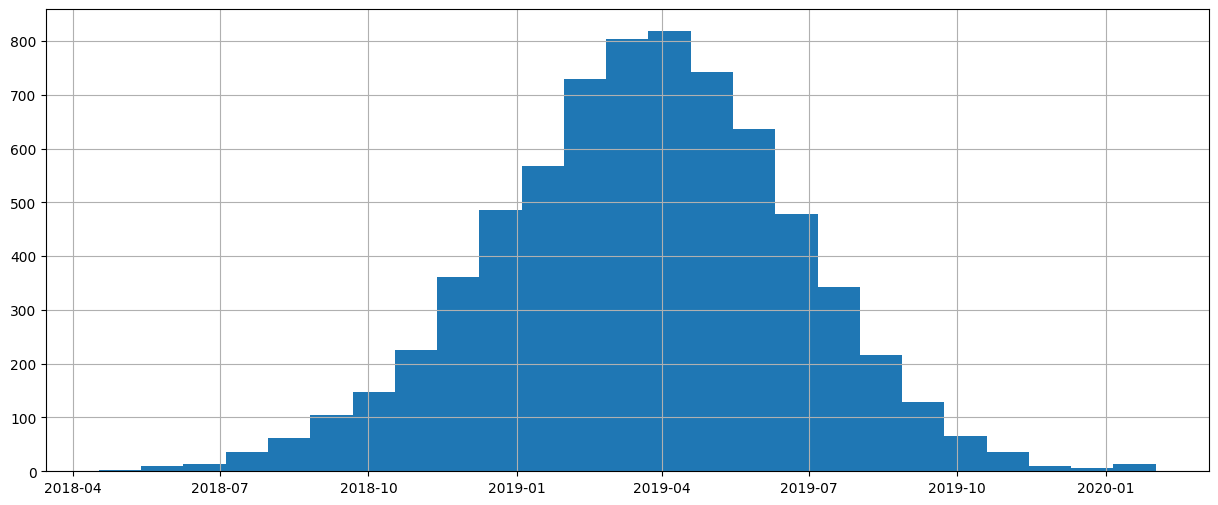

In [18]:
df_contract['BeginDate'].hist(bins=25, figsize=(15, 6))
None

Распределение данных по дате начала пользования услугами оператора выглядит нормальным. В столбце есть данные с апреля 2018 года по январь 2020 года.

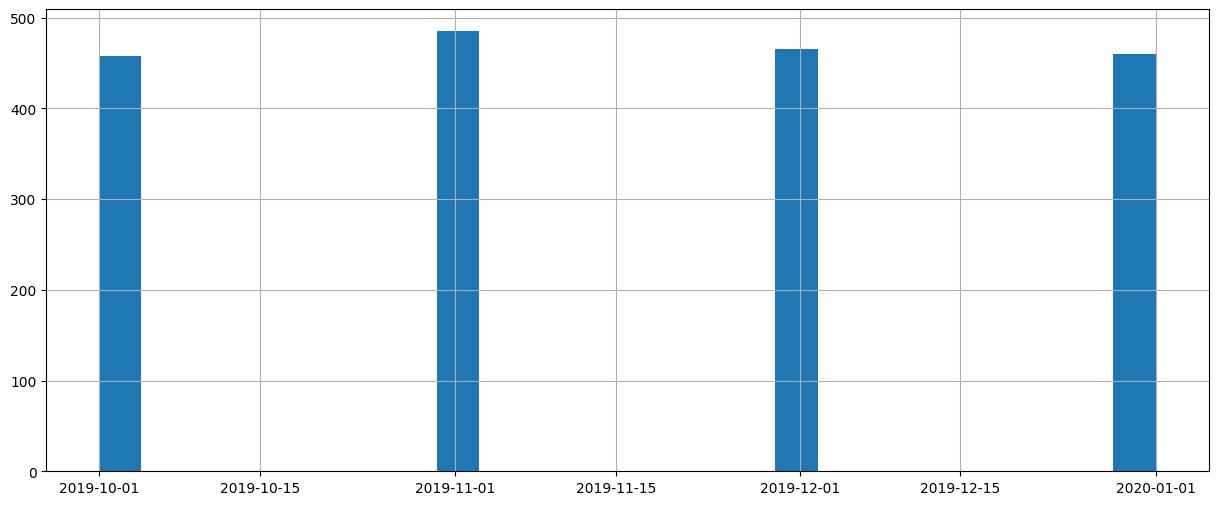

In [19]:
df_contract['EndDate'].hist(bins=25, figsize=(15, 6))
None

Распределение данных по дате прекращения пользования услугами оператора выглядит странно. Нет данных о расторжении договоров с оператором раньше октября 2019 года. Пик расторжений приходится на начало месяца. В середине месяца расторжений нет.

#### Проверяю данные на наличие неявных пропусков/ошибок

In [20]:
df_contract['PaymentMethod'].unique()

In [21]:
df_contract['PaperlessBilling'].unique()

In [22]:
df_contract['Type'].unique()

#### Изучаю подробнее численные столбцы

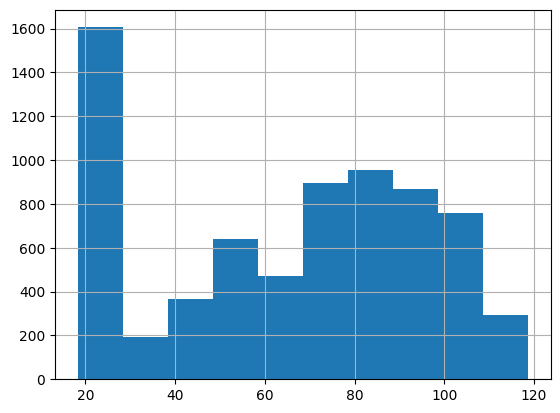

In [23]:
df_contract['MonthlyCharges'].hist()
None

В столбце "Расходы за месяц" выброс около 20 рублей. Т.е. у значительного числа абонентов ежемесячные расходы на связь составляют около 20 рублей.\
Потом идет нормальное распределение ежемесчных расходов абонентов на связь в пределах от 40 до 120 рублей.

#### Ниже смотрю общий расход абонента

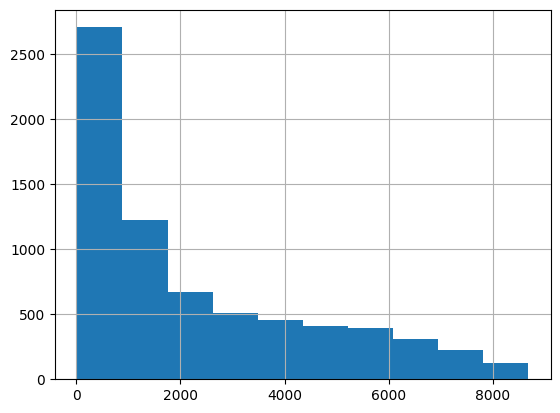

In [24]:
df_contract['TotalCharges'].hist()
None

Распределение от 0 до 8000 руб. за весь период

Изучаю подробнее кусочек графика от 0 до 2000 руб

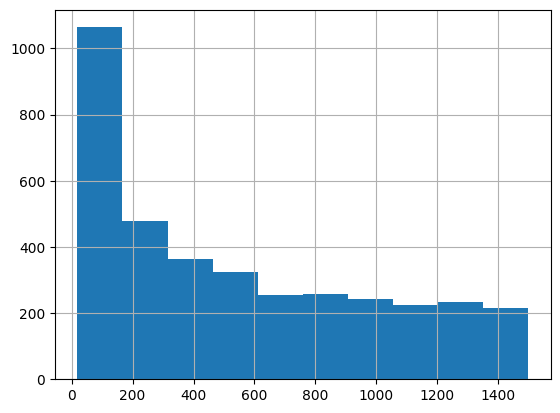

In [25]:
df_contract.query('TotalCharges<1500')['TotalCharges'].hist()
None

Больше, чем у 1000 абонентов общий расход на связь не превысил 200 рублей за весь период пользования услугами оператора.

**Вывод:**
\
Я изучила таблицу contract.\
В столбце TotalCharges - Общий расход абонента - были незначительное число пропусков (меньше 1%), эти пропуски я удалила.\
\
Распределение данных по дате начала пользования услугами оператора выглядит нормальным. В столбце есть данные с апреля 2018 года по январь 2020 года.\
Распределение данных по дате прекращения пользования услугами оператора выглядит странно. Нет данных о расторжении договоров с оператором раньше октября 2019 года. Пик расторжений приходится на начало месяца. В середине месяца расторжений нет.\
\
В столбце "Расходы за месяц" выброс около 20 рублей. Т.е. у значительного числа абонентов ежемесячные расходы на связь составляют около 20 рублей.\
Потом идет нормальное распределение ежемесчных расходов абонентов на связь в пределах от 40 до 120 рублей.\
\
Больше, чем у 1000 абонентов общий расход на связь не превысил 200 рублей за весь период пользования услугами оператора.\
Распределение общего расхода на связь среди абонентов за все время пользования услугами оператора составляет от примерно 100 рублей до 1500 рублей.

### Изучаю подробнее таблицу personal

In [26]:
df_personal.info()

#### Изучаю подробнее столбцы таблицы personal

In [27]:
df_personal['gender'].unique()

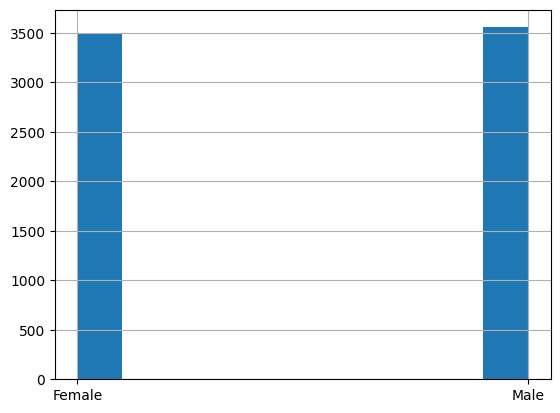

In [28]:
df_personal['gender'].hist()
None

In [29]:
df_personal['SeniorCitizen'].unique()

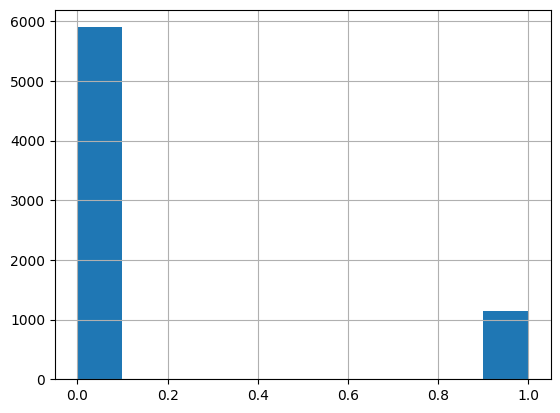

In [30]:
df_personal['SeniorCitizen'].hist()
None

In [31]:
df_personal['Partner'].unique()

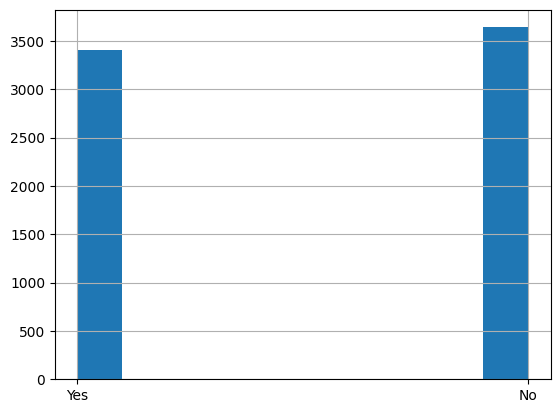

In [32]:
df_personal['Partner'].hist()
None

In [33]:
df_personal['Dependents'].unique()

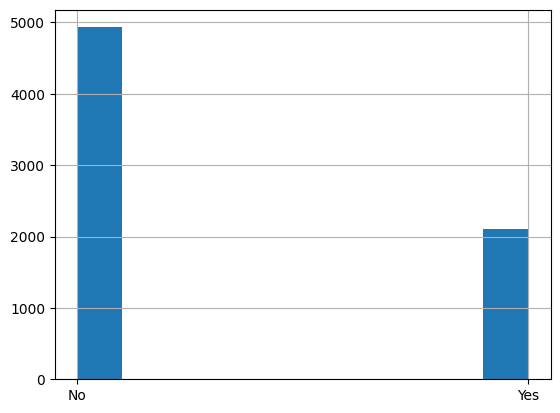

In [34]:
df_personal['Dependents'].hist()
None

**Вывод:**
\
Пропусков и аномальных значений в таблице personal нет.\
Мужчин/женщин среди абонентов примерно поровну.\
Пенсионеров среди абонентов примерно 1/6 часть.\
Абонентов с партнером/без партнера - примерно равное количество. Одиноких абонентов немного больше.\
Дети есть чуть меньше, чем у половины абонентов.

### Изучаю подробнее таблицу internet

In [35]:
df_internet.info()

#### Наименования столбцов не соответствуют документации. Пользоваться такой таблицей будет не удобно, поэтому переименовываю столбцы

In [36]:
df_internet = df_internet.rename(columns={'c1':'customerID', 'c2':'InternetService', 'c3':'OnlineSecurity', 'c4':'OnlineBackup', 'c5':'DeviceProtection',\
                                          'c6':'TechSupport', 'c7':'StreamingTV', 'c8':'StreamingMovies'})

In [37]:
df_internet.info()

Удаляю нулевую строку, в которой было дублировано название столбцов

In [38]:
df_internet = df_internet.loc[1:]

In [39]:
df_internet.head(5)

#### Изучаю подробнее столбцы таблицы personal

In [40]:
df_internet['InternetService'].unique()

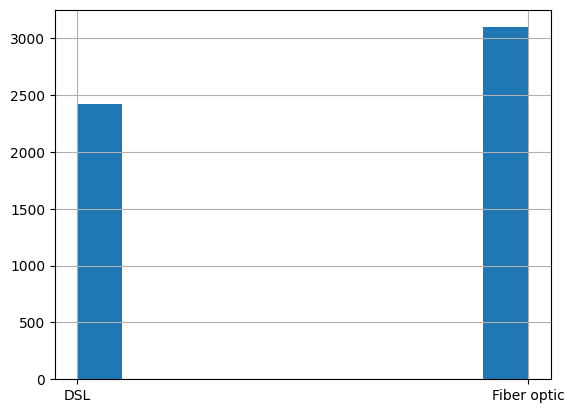

In [41]:
df_internet['InternetService'].hist()
None

In [42]:
df_internet['OnlineSecurity'].unique()

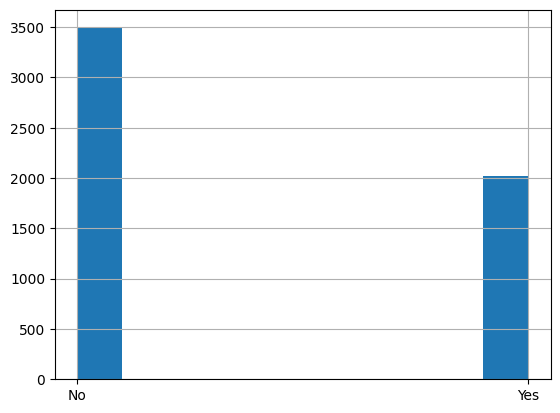

In [43]:
df_internet['OnlineSecurity'].hist()
None

In [44]:
df_internet['OnlineBackup'].unique()

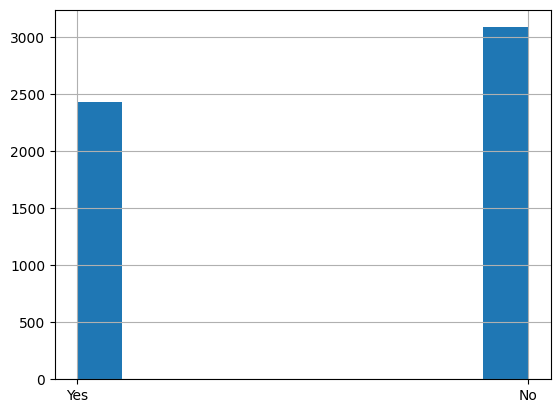

In [45]:
df_internet['OnlineBackup'].hist()
None

In [46]:
df_internet['DeviceProtection'].unique()

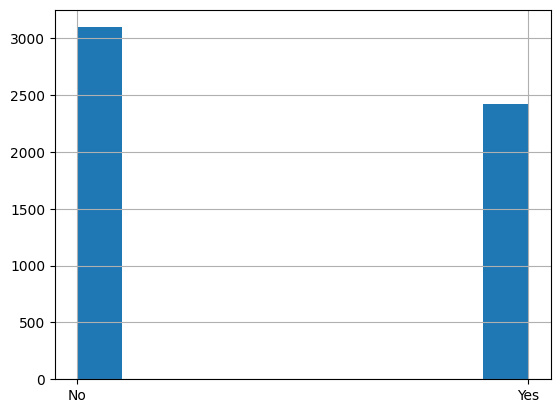

In [47]:
df_internet['DeviceProtection'].hist()

In [48]:
df_internet['TechSupport'].unique()

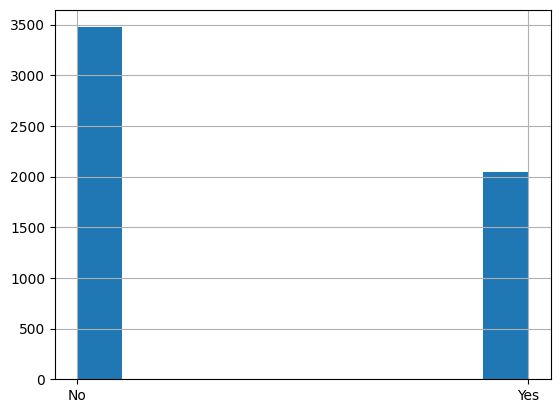

In [49]:
df_internet['TechSupport'].hist()

In [50]:
df_internet['StreamingTV'].unique()

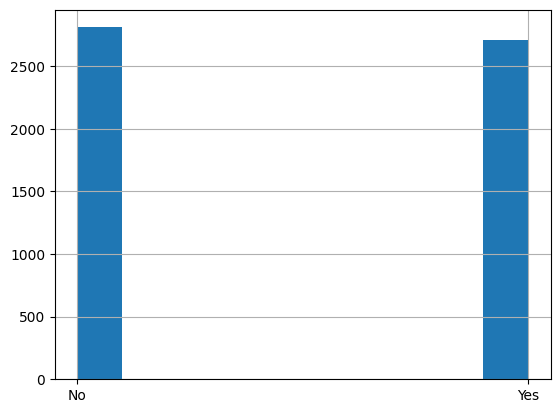

In [51]:
df_internet['StreamingTV'].hist()
None

In [52]:
df_internet['StreamingMovies'].unique()

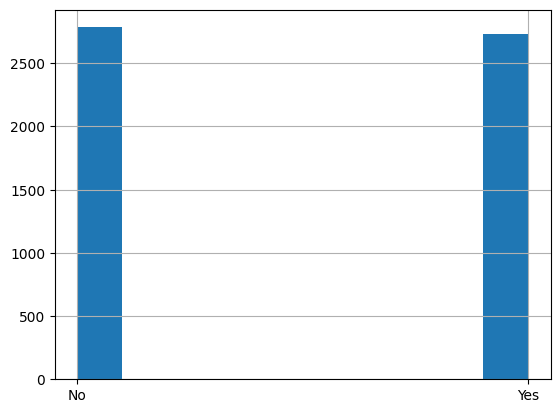

In [53]:
df_internet['StreamingMovies'].hist()
None

**Вывод:**
\
В таблице Интернет информация есть не о всех пользователях: интернетом пользуются 5518 пользователей из 7043 пользователей.\
Для удобства пользования таблицей я переименовала названия столбцов, чтобы они соответствовали названиям из документации.\
Я подробнее изучила данные в таблице: аномальных значений не обнаружила.

### Изучаю подробнее таблицу phone

In [54]:
df_phone.info()

In [55]:
df_phone.head(5)

#### Переименовываю столбцы, чтобы названия соответствовали документации

In [56]:
df_phone = df_phone.rename(columns={'c1':'customerID', 'c2':'MultipleLines'})

Удаляю нулевую строку

In [57]:
df_phone = df_phone.loc[1:]
df_phone.head(5)

#### Изучаю столбец MultipleLines в таблице Phone

In [58]:
df_phone['MultipleLines'].unique()

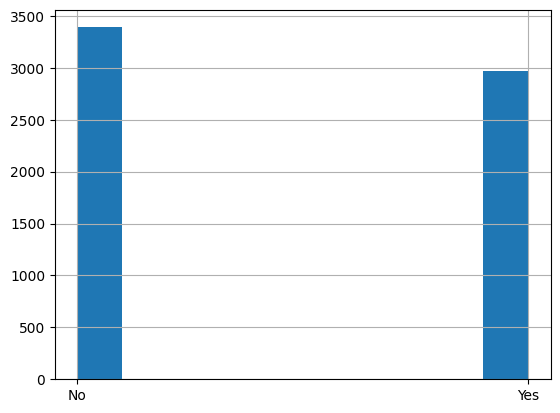

In [59]:
df_phone['MultipleLines'].hist()
None

**Вывод:**
\
В таблице Phone информация есть не о всех пользователях: телефоном пользуются 6361 пользователей из 7043 пользователей.\
Для удобства пользования таблицей я переименовала названия столбцов, чтобы они соответствовали названиям из документации.\
Я подробнее изучила данные в таблице: аномальных значений не обнаружила.

### Объединяю таблицы по ID клиента

In [60]:
df = df_contract.merge(df_personal, on=['customerID'], how='outer')

In [61]:
df = df.merge(df_internet, on=['customerID'], how='outer')

In [62]:
df = df.merge(df_phone, on=['customerID'], how='outer')

In [63]:
df.info()

In [64]:
df.head(10)

#### Обработка пропусков в столбце EndDate

У меня нет данных, чтобы заполнить пропуски в столбце EndDate. Заполняю пропуски датой, равной дате выгрузки данных: 2020-02-01

In [65]:
df['EndDate'] = df['EndDate'].fillna(pd.to_datetime('2020-02-01'))

#### Создаю столбец: период действия контракта

Пишу функцию для заполнения столбца "Период действия контракта"

In [66]:
def date_duration (row):
    #возвращает количество дней действия контракта
    begin_date = row['BeginDate']
    end_date = row['EndDate']
    return end_date - begin_date

Применяю функцию

In [67]:
df['date_duration_days'] = df.apply(date_duration, axis=1)

In [68]:
df.head(15)

#### Заполняю пропуски в столбце TotalCharges

Сначала удалим пропуски в TotalCharges

In [69]:
df = df.drop(df[df['TotalCharges'].isna()].index, axis=0)
df = df.reset_index(drop=True)

#### Заполняю пропуски в столбцах InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies

In [70]:
df[['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']] = \
df[['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']].fillna('unknown')

In [71]:
df.info()

#### Создаю столбец с целевой переменной: 0 - действующий договор, 1 - расторгнутый договор

Пишу функцию, которая берет данные из столбца EndDate. Если договор расторгнут, то вписываю в новый столбец 1, если договор не расторгнут, то 0.

In [72]:
def canceled (row):
    end_date = row['EndDate']
    if end_date == (pd.to_datetime("2020-02-01")):
        return 0
    else:
        return 1

In [73]:
df['is_canceled'] = df.apply(canceled, axis=1)

In [74]:
df[['EndDate', 'is_canceled', 'date_duration_days']].head(15)

Пропусков в сводной таблице больше не осталось.

#### Создаю столбец прибыль от абонента в день

In [75]:
def day_profit (row):
    days = pd.to_numeric(row['date_duration_days'].days, downcast='integer')
    total_profit = row['TotalCharges']
    if days == 0:
        return 0
    else:
        return total_profit/days

In [76]:
df['day_profit'] = df.apply(day_profit, axis=1)

In [77]:
df[['date_duration_days', 'TotalCharges', 'day_profit']].head(15)

#### Вывожу графики распределения всех признаков сводной таблицы

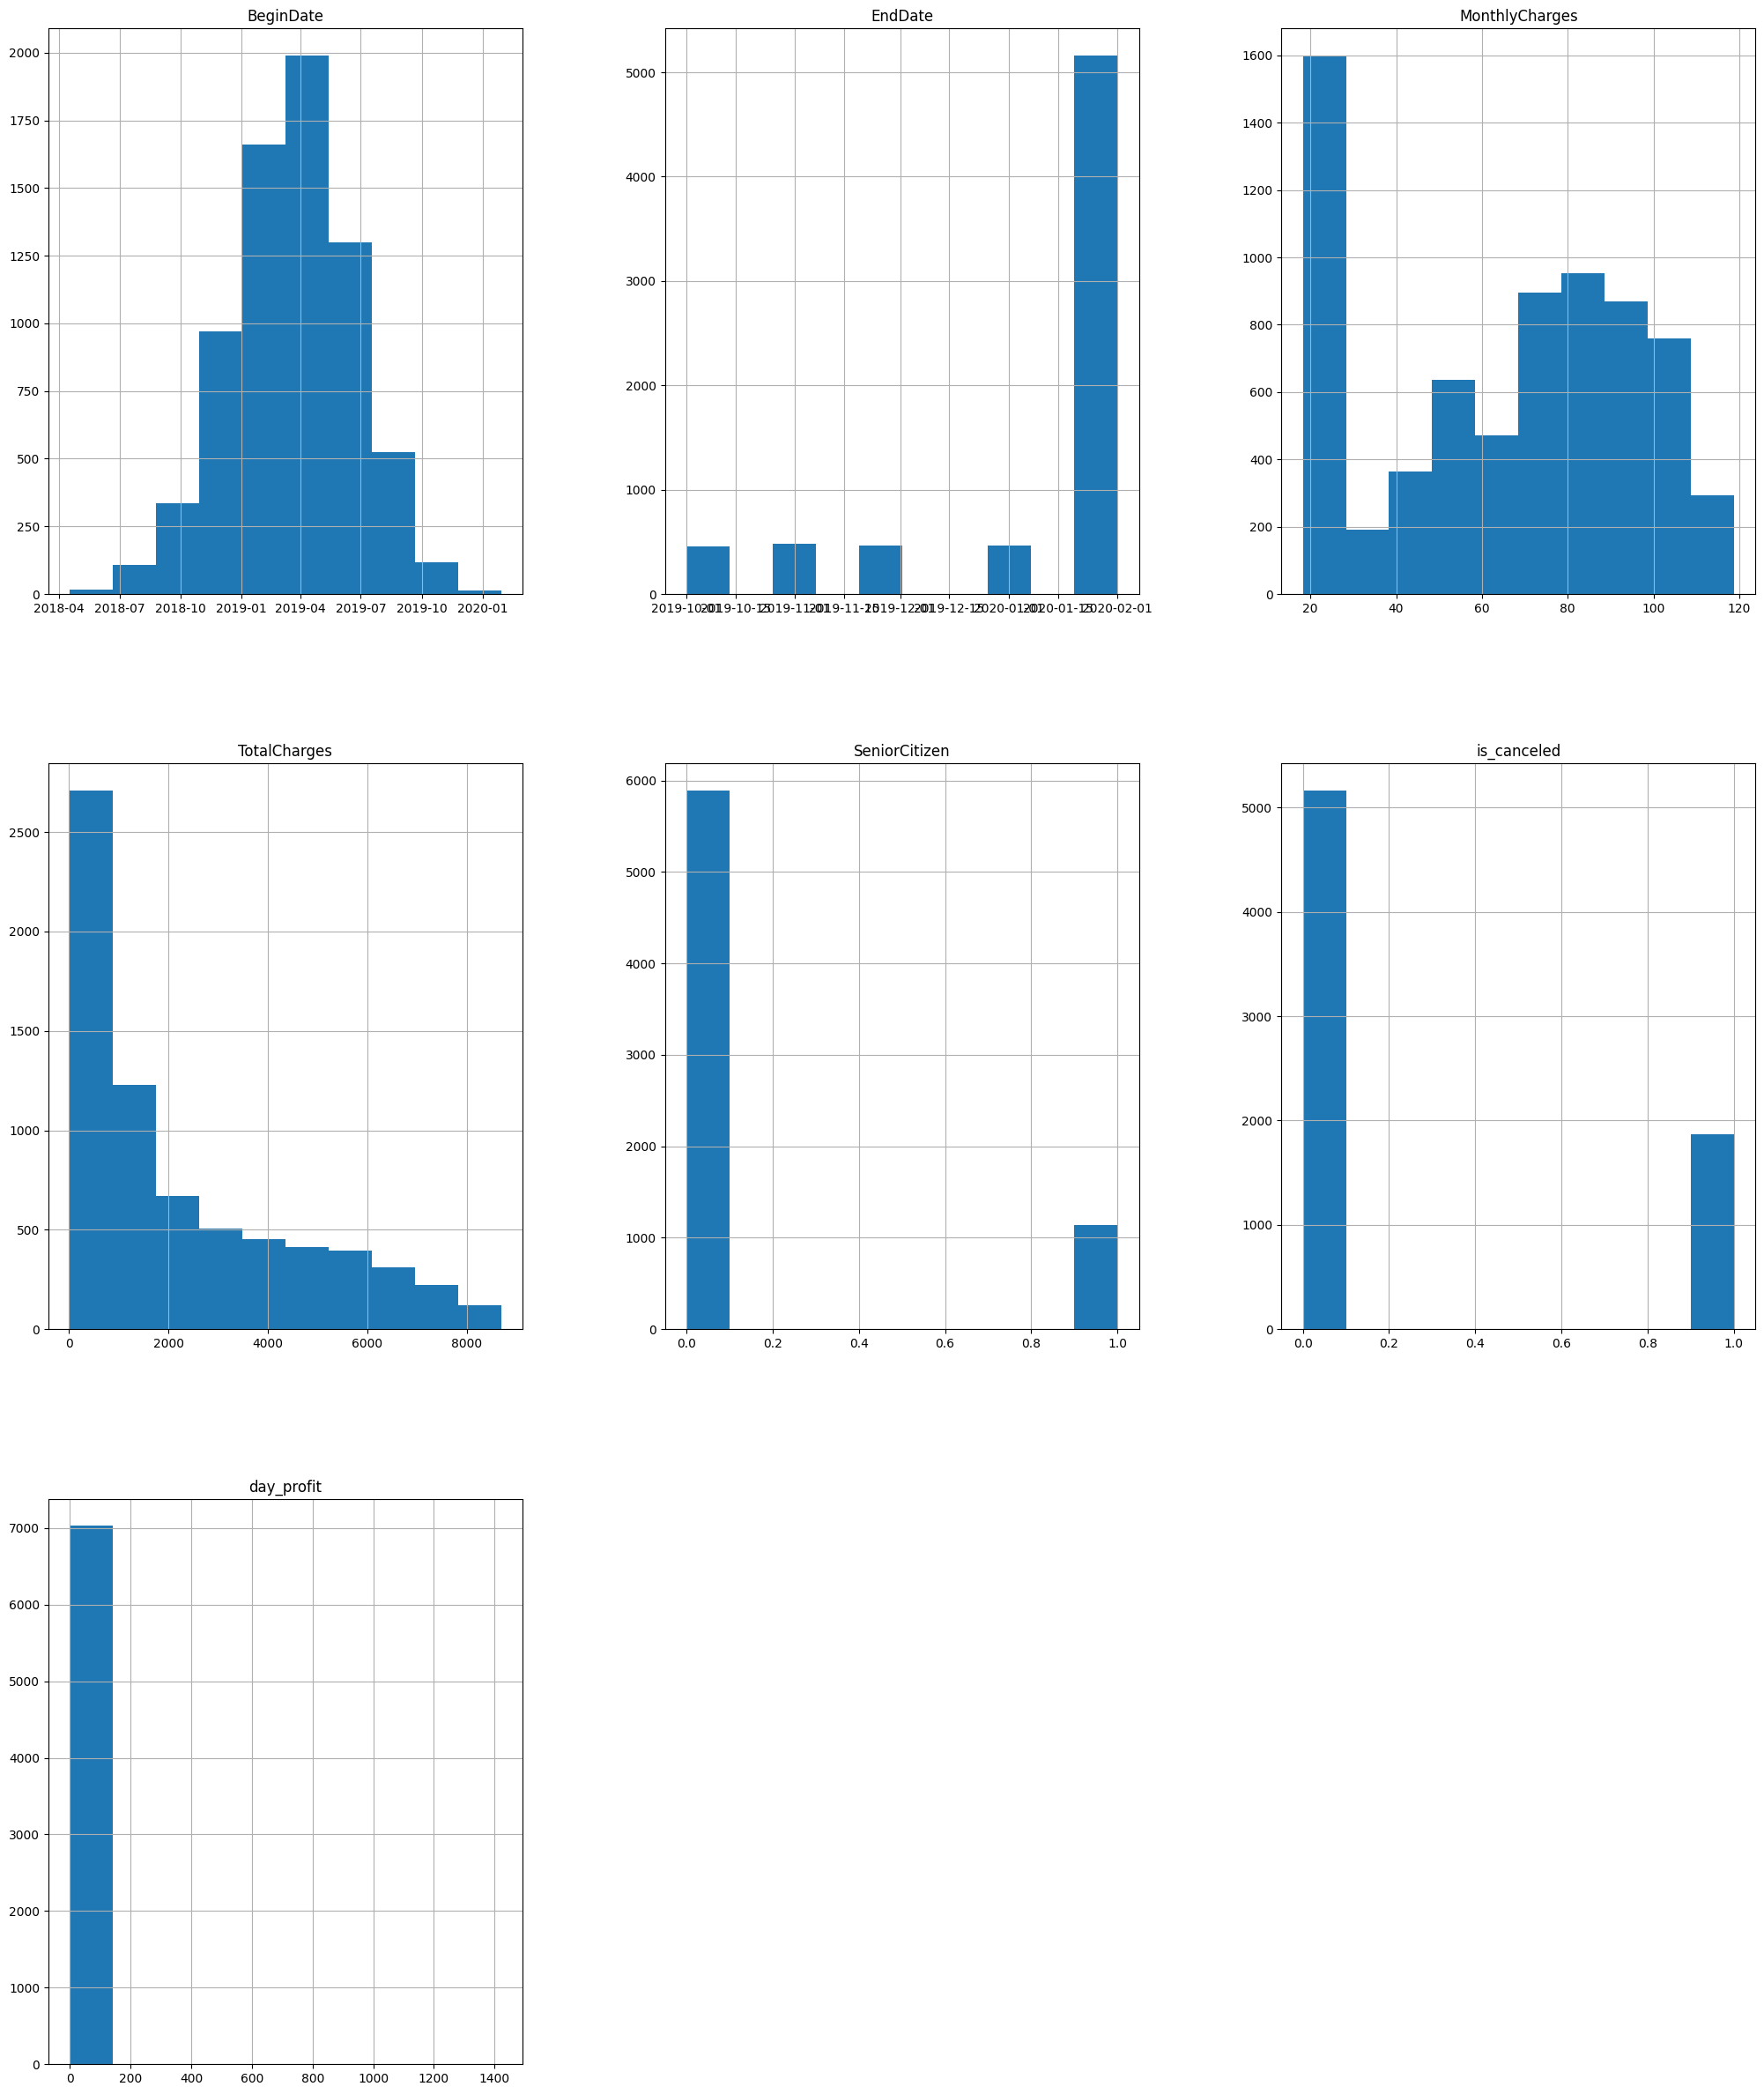

In [78]:
df.drop(['customerID'], axis=1).hist(figsize=(25,30))
None

#### Вывожу матрицу корреляций

Вывожу матрицу корреляций между всеми признаками

In [79]:
df.drop(['BeginDate', 'EndDate', 'date_duration_days'], axis=1).phik_matrix()

Наибольшая корреляция отмечена между размером ежемесячных платежей и типом подключения, а также между размером ежемесячных платежей и различными интернет-сервисами: облачное хранилище, антивирус и пр. Это и логично: за доп услуги нужно платить, поэтому наличие доп услуг связано с бОльшей ежемесячной оплатой.

### Подготовка данных для обучения

#### Исследование дисбаланса классов в целевой переменной

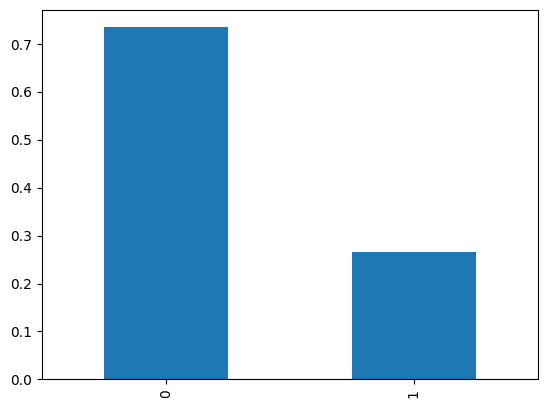

In [80]:
class_frequency = df['is_canceled'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')
None

В целевом столбце выявлен дисбаланс классов. Нулей примерно втрое больше, чем единиц.

#### Разбиваю данные на выборки

In [81]:
features = df.drop(['customerID', 'BeginDate', 'EndDate', 'is_canceled', 'date_duration_days', 'gender', 'TotalCharges'], axis=1)
target = df['is_canceled']

features_train, features_test, target_train, target_test = train_test_split(features, \
                                                                            target, \
                                                                            test_size=0.25, \
                                                                            random_state=RANDOM_STATE, \
                                                                           stratify=target) #делю данные 65-25%

print(f"Количество строк в target_train по классам: {np.bincount(target_train)}")
print(f"Количество строк в target_test по классам: {np.bincount(target_test)}")

#### Масштабирую количественные данные

In [82]:
numeric = ['MonthlyCharges', 'day_profit']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

print(features_train.shape)
display (features_train.head(5))
display (features_test.head(5))

#### Кодирую категориальные значения

In [83]:
categories = ['Type', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen', 'Partner', 'Dependents', \
                                'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', \
                    'StreamingTV', 'StreamingMovies', 'MultipleLines']
onehot_encoder = OneHotEncoder(sparse=False, handle_unknown='error', drop='first')

result_train_ohe = onehot_encoder.fit_transform(features_train[categories])
result_train = pd.DataFrame(result_train_ohe, columns=onehot_encoder.get_feature_names_out(categories),\
                                                                        index=features_train.index)
features_train_ohe = result_train.join(features_train[numeric])
features_train_ohe.head()

In [84]:
result_test_ohe = onehot_encoder.transform(features_test[categories])
result_test = pd.DataFrame(result_test_ohe, columns=onehot_encoder.get_feature_names_out(categories),\
                                                                        index=features_test.index)
features_test_ohe = result_test.join(features_test[numeric])
features_test_ohe.head()

### Исследую модель случайного леса

#### Для исследования моделей, основанных на деревьях решений, использую порядковое кодирование

In [85]:
# порядковое кодирование
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
cat_columns = ['Type', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen', 'Partner', 'Dependents', \
                                'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', \
                               'MultipleLines']
encoder.fit(features_train[cat_columns])

features_train_ord = features_train.copy()
features_test_ord = features_test.copy()

features_train_ord[cat_columns] = encoder.transform(features_train_ord[cat_columns])
features_test_ord[cat_columns] = encoder.transform(features_test_ord[cat_columns])

#### Масштабирую признаки столбцов

In [86]:
numeric = ['MonthlyCharges', 'day_profit']

scaler = StandardScaler()
scaler.fit(features_train_ord[numeric])
features_train_ord[numeric] = scaler.transform(features_train_ord[numeric])
features_test_ord[numeric] = scaler.transform(features_test_ord[numeric])

print(features_train_ord.shape)
display (features_train_ord.head(5))
display (features_test_ord.head(5))

#### Исследую модель случайного леса. Гиперпараметры подбираю через GridSearch

In [87]:
kf = StratifiedKFold(n_splits=5)

In [88]:
%%time

clf = RandomForestClassifier (random_state=RANDOM_STATE) #объявляем классификатор

param = { 'n_estimators': range(50, 200, 50), 'max_depth': [None] + [i for i in range(2, 9)] } #задаем параметры классификатора

grid = GridSearchCV(estimator = clf,
                    param_grid = param,
                    cv = kf,
                    n_jobs = -1,
                    verbose = 0,
                    scoring = 'roc_auc') #запускаем обучение
grid.fit(features_train_ord, target_train)

print ('Roc-auc наилучшей модели', grid.best_score_) #выводим наилучшую метрику
print ('Какие гиперпараметры дали наилучший результат', grid.best_params_) #выводим наилучшие параметры модели

### Исследую модель LightGBM

In [89]:
%%time

clf = lgb.LGBMClassifier (boosting_type='gbdt',  objective='binary', \
                          learning_rate=0.02, metric='roc_auc', random_state=RANDOM_STATE) #объявляем классификатор

param = { 'n_estimators': range(50, 200, 50), 'max_depth': [i for i in range(3, 12)]} #задаем параметры классификатора

grid = GridSearchCV(estimator = clf,
                    param_grid = param,
                    cv = kf,
                    n_jobs = -1,
                    verbose = 0,
                    scoring = 'roc_auc') #запускаем обучение
grid.fit(features_train_ohe, target_train)

print ('Roc-auc наилучшей модели', grid.best_score_) #выводим наилучшую метрику
print ('Какие гиперпараметры дали наилучший результат', grid.best_params_) #выводим наилучшие параметры модели

### Исследую модель CatBoost

In [90]:
%%time

clf = CatBoostClassifier (random_state=RANDOM_STATE) #объявляем классификатор

param = {'max_depth': [i for i in range(5, 12)],
                  'learning_rate':[0.01, 0.1],
                  'iterations': [400, 500]}  #задаем параметры классификатора


grid = GridSearchCV(estimator = clf,
                    param_grid = param,
                    cv = kf,
                    n_jobs = -1,
                    verbose = 0,
                    scoring = 'roc_auc') #запускаем обучение
grid.fit(features_train_ohe, target_train)
print(grid.best_params_)
grid.best_score_

### Построение базовой нейронной сети

#### Создаю класс для задания архитектуры нейронной сети и обучаю сеть

In [91]:
%%time

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid') # 1 потому что, это бинарная классификация
])

#Компилирую модель
model.compile(
    loss = tf.keras.losses.binary_crossentropy,
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.02),
    metrics = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.AUC(name='ROC')
    ]
)
hist = model.fit(features_train_ohe, target_train, epochs=50)

Я исследовала модели:
1. Случайного леса ROC-AUC 0.845 (на тренировочной выборке)
2. LightGBM ROC-AUC 0.8454 (на тренировочной выборке)
3. CatBoost ROC_AUC 0.8471 (на тренировочной выборке)
4. Нейронной сети 0.84 (на тренировочной выборке)

Наилучший результат на тренировочной выборке показала модель CatBoost. Ниже ее тестирую.

### Тестирование модели

#### Проверка на тестовой выборке модели CatBoost

In [92]:
best_model = CatBoostClassifier(random_state=RANDOM_STATE,
                           iterations = 400,
                           learning_rate = 0.01,
                           max_depth = 5).fit(features_train_ohe, target_train)

In [93]:
y_pred_proba = best_model.predict_proba(features_test_ohe)[:, 1]
auc_roc = roc_auc_score(target_test, y_pred_proba)

print('AUC-ROC на тестовой выборке:', round(auc_roc, 4))


### Вывожу матрицу ошибок

Записываю предсказания модели в отдельную переменную test_preds

In [95]:
test_preds = best_model.predict(features_test_ohe)
print (test_preds)

Округляю предсказания и создаю переменную "Предсказанная вероятность - preds_probability"

In [96]:
preds = pd.DataFrame(test_preds)
preds_probability = round(preds,0)
print (preds_probability)

Создаю матрицу ошибок

In [97]:
confusion_matrix(target_test, preds_probability)

Результат матрицы ошибок:\
Истинно позитивное предсказание 1133, ошибочно негативные 204, ошибочно положительные 161, ошибочно отрицательное 263

Вычисляю Accuracy для лучшей модели

In [98]:
Accuracy = accuracy_score(preds_probability, target_test)
print (Accuracy)

#### Исследую важность признаков у лучшей модели

In [99]:
# сгенерируем оценщик значений Шепли, который соответствует построенной модели бустинга
explainer = shap.TreeExplainer(best_model, feature_perturbation='interventional')
# вычислим значения Шепли для тестовой выборки
shap_values = explainer.shap_values(features_test_ohe)

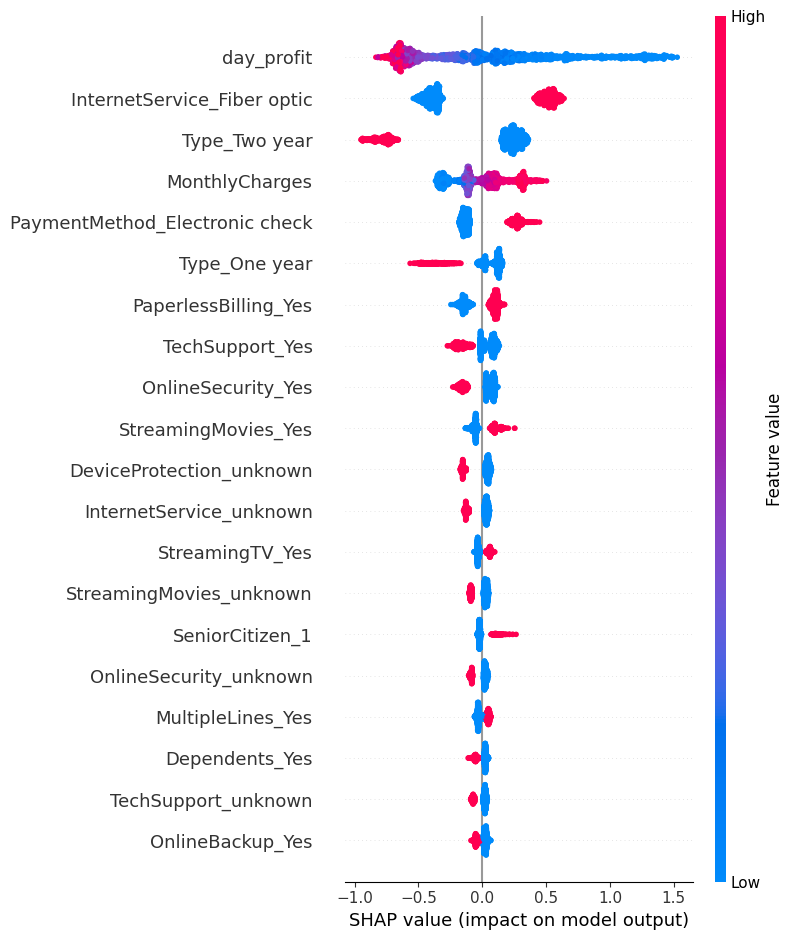

In [100]:
shap.summary_plot(shap_values, features_test_ohe)

Наиболее важными признаками оказались: тип оплаты, сумма ежемесячной оплаты, сумма общей оплаты.

## Вывод

Оператор связи «ТелеДом» борется с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах.\
\
Я обучила модель на предоставленных данных. Наилучший результат показала модель CatBoost. ROC-AUC на тестовых данных получились 0,85.\
\
Наиболее важными признаками оказались: тип оплаты, сумма ежемесячной оплаты, сумма общей оплаты.